<a href="https://colab.research.google.com/github/tousif-anwar/AI-Driven-Spatial-Optimization-of-Wave-Energy-Farms/blob/main/Copy_of_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 614 - Applications of Machine Learning
## Programming Assignment 3 - Transfer Learning for Image Classification

### Introduction
We're going to load a ResNet18 model trained using the IMAGENET 1K dataset, and then modify and fine-tune it to work on the CIFAR10 dataset.

### Download, Import, and Transform the Data
First lets load our data.   We'll download it directy from Pytorch.  We'll reshape each image to $224\times 224$ and standardize it using a previuosly known mean and standard deviation.

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch import nn

batch_size = 64
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                               transform = transforms.Compose([
                                                    transforms.Resize((224,224)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
                                               download = True)

test_dataset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                               transform = transforms.Compose([
                                                    transforms.Resize((224,224)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
                                               download = True)


#NEW:  changed shuffle to false so that each epoch we get the same batch
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]


100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


In [ ]:
print("CIFAR-10 Dataset")
print(f"Train observations: {len(train_dataset)}")
print(f"Test observations : {len(test_dataset)}")
print("Feature shape (after transform):", train_dataset[0][0].shape)
print("Label type: integer class index (0-9)")

CIFAR-10 Dataset
Train observations: 50000
Test observations : 10000
Feature shape (after transform): torch.Size([3, 224, 224])
Label type: integer class index (0-9)


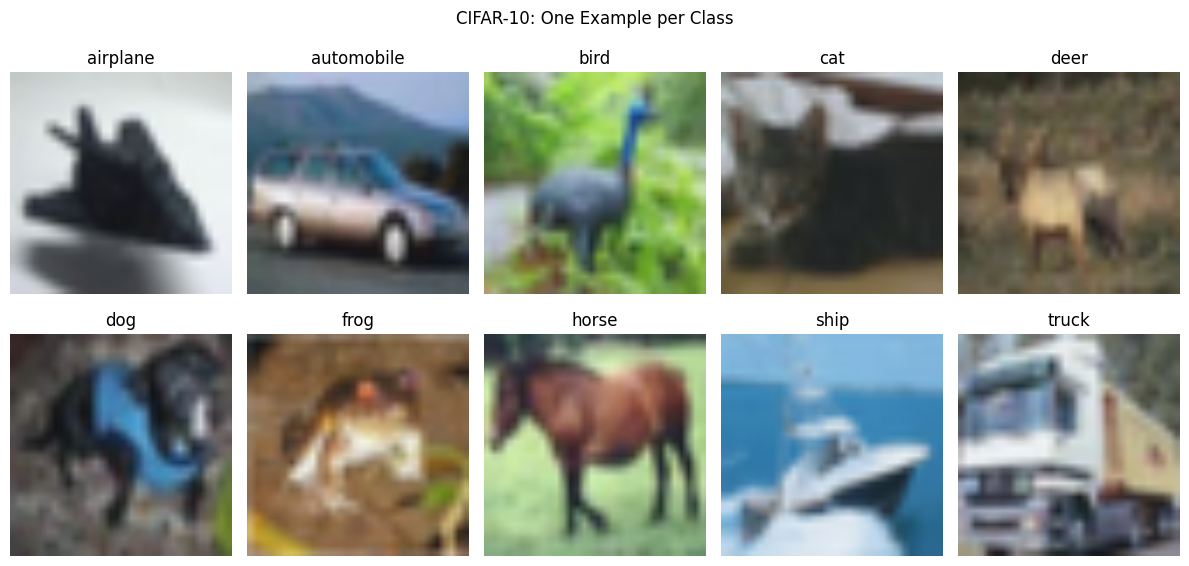

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
std  = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1)

def denorm(x):
    return torch.clamp(x * std + mean, 0, 1)

seen = set()
examples = [None]*10

for img, y in train_dataset:
    if y not in seen:
        examples[y] = (img, y)
        seen.add(y)
    if len(seen) == 10:
        break

plt.figure(figsize=(12,6))
for i, (img, y) in enumerate(examples):
    ax = plt.subplot(2,5,i+1)
    ax.imshow(denorm(img).permute(1,2,0))
    ax.set_title(classes[y])
    ax.axis("off")
plt.suptitle("Examples per Class")
plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter

counts = Counter()
for _, y in train_dataset:
    counts[int(y)] += 1

priors = {classes[k]: v/len(train_dataset) for k,v in sorted(counts.items())}
print("Class Priors (Train):")
for k,v in priors.items():
    print(f"{k:>10s}: {v:.4f}")


Class Priors (Train):
  airplane: 0.1000
automobile: 0.1000
      bird: 0.1000
       cat: 0.1000
      deer: 0.1000
       dog: 0.1000
      frog: 0.1000
     horse: 0.1000
      ship: 0.1000
     truck: 0.1000


### Load Pre-Trained Model
Next let's load a ResNet18 model pretrained using the ImageNet1K dataset

In [ ]:
#get model trained with Imagenet1k
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
#print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Freeze the Existing Network
When we fine-tune our model, we don't want to backpropagate the layers related to the pre-trained ResNet model

In [ ]:
#don't backprop old architecture
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for param in model.fc.parameters():
    param.requires_grad = True

### Alter the Last Fully Connected Layer for our New Dataset
We will need to change the last layer (model.fc) to be a linear layer that takes us down to 10 classes (required for CIFAR10 dataset)

In [ ]:
num_ftrs = model.fc.in_features  #number of features in to last fully-connected layer
model.fc = nn.Linear(num_ftrs,10) #change it!

### Objective and Optimizer
The next thing we need for our model is an objective function and optimizer.  Make your choices!

In [ ]:
#TODO
#Create loss function and optimizer, choosing hyperparameters, as appropriate
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=5e-4
)

### Fine-Tune Model using CIFAR10 Training Set
Now fine-tune your model using the CIFAR10 dataset.
Again, keep track of the training loss to plot, then report final training and testing accuarcies.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [1/10]  Loss: 0.5848  Time: 131.54s
Epoch [2/10]  Loss: 0.5756  Time: 131.72s
Epoch [3/10]  Loss: 0.5684  Time: 129.87s
Epoch [4/10]  Loss: 0.5626  Time: 130.65s
Epoch [5/10]  Loss: 0.5577  Time: 127.92s
Epoch [6/10]  Loss: 0.5536  Time: 128.90s
Epoch [7/10]  Loss: 0.5501  Time: 127.19s
Epoch [8/10]  Loss: 0.5470  Time: 129.26s
Epoch [9/10]  Loss: 0.5442  Time: 127.15s
Epoch [10/10]  Loss: 0.5417  Time: 129.62s

Total Training Time: 1293.82s
Avg Epoch Time: 129.38s


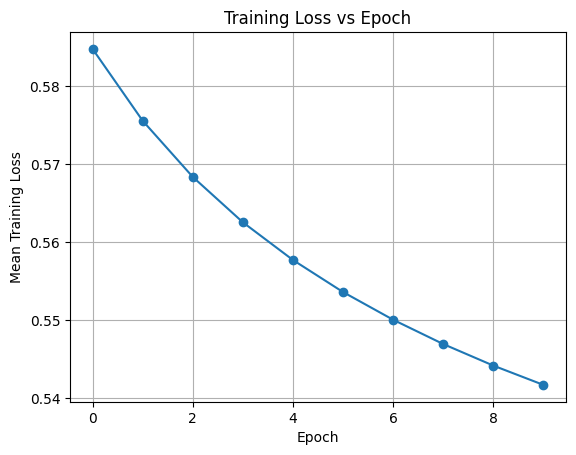

In [ ]:
import time
import torch
import matplotlib.pyplot as plt

num_epochs = 10
NUM_BATCHES = None

epoch_losses = []
epoch_times = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_start = time.time()

    running_loss = 0.0
    steps = 0

    for i, (images, labels) in enumerate(train_loader):
        if NUM_BATCHES is not None and i >= NUM_BATCHES:
            break

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels);

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        steps += 1

    mean_loss = running_loss / max(steps, 1)
    epoch_losses.append(mean_loss)

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {mean_loss:.4f}  Time: {epoch_time:.2f}s")

total_time = time.time() - start_time
print(f"\nTotal Training Time: {total_time:.2f}s")
print(f"Avg Epoch Time: {total_time/num_epochs:.2f}s")

### Report Statistics and Provide Examples
Finally, provide your training plot, training and testing accuracies and examples of success and failure cases.

In [ ]:
@torch.no_grad()
def accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total

train_acc = accuracy(model, train_loader, device)
test_acc  = accuracy(model, test_loader, device)

print(f"Final Training Accuracy: {train_acc*100:.2f}%")
print(f"Final Testing  Accuracy: {test_acc*100:.2f}%")

Final Training Accuracy: 81.97%
Final Testing  Accuracy: 80.82%


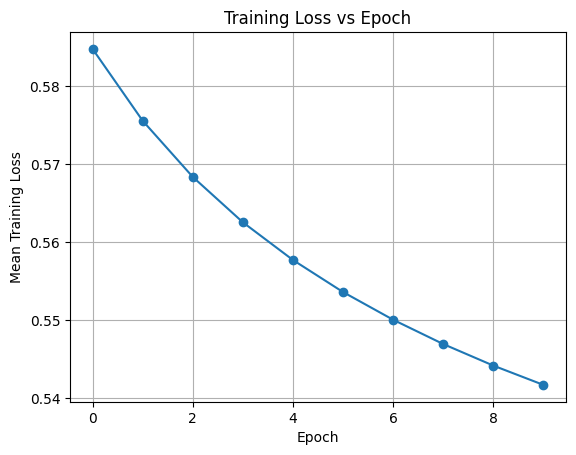

In [ ]:
plt.figure()
plt.plot(epoch_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Mean Training Loss")
plt.title("Training Loss vs Epoch")
plt.grid(True)
plt.show()

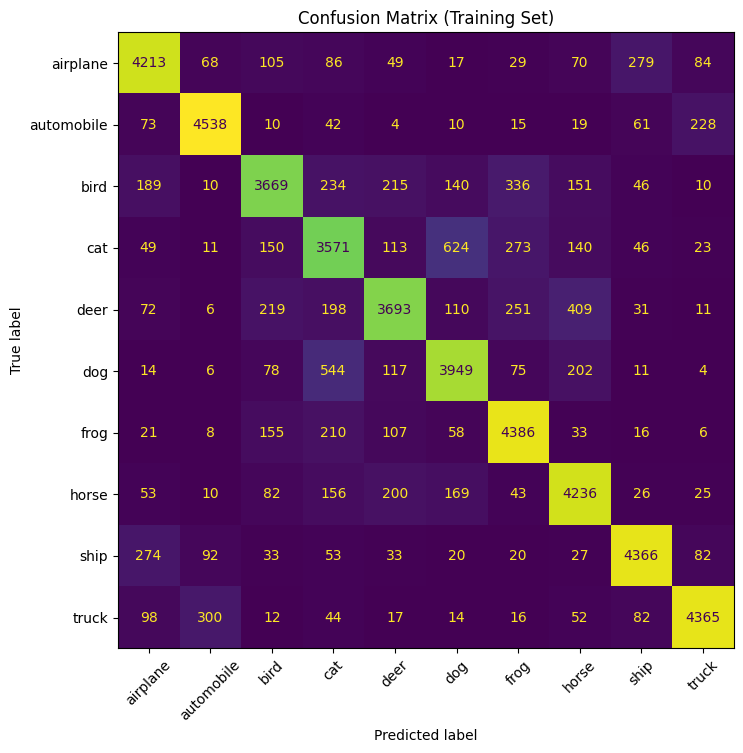

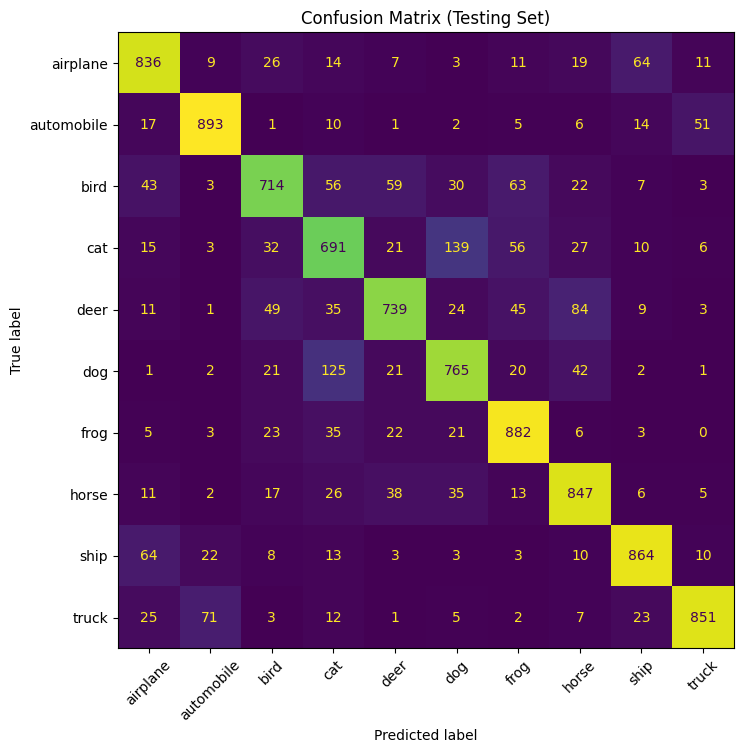

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

@torch.no_grad()
def get_preds(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    for images, labels in loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.append(preds)
        y_true.append(labels.numpy())
    return np.concatenate(y_true), np.concatenate(y_pred)

y_true_tr, y_pred_tr = get_preds(model, train_loader, device)
cm_tr = confusion_matrix(y_true_tr, y_pred_tr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_tr, display_labels=classes)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title("Training Set")
plt.show()

y_true_te, y_pred_te = get_preds(model, test_loader, device)
cm_te = confusion_matrix(y_true_te, y_pred_te)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_te, display_labels=classes)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title("Testing Set")
plt.show()


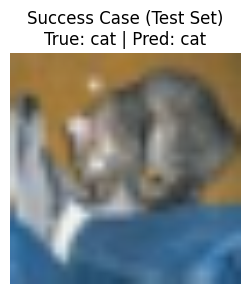

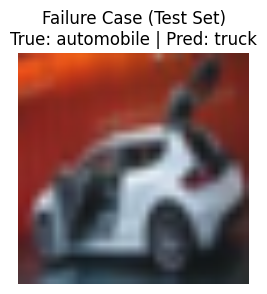

In [ ]:
@torch.no_grad()
def find_one_success_one_failure(model, loader, device):
    model.eval()
    success = None
    failure = None

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            img = images[i].detach().cpu()
            y = labels[i].item()
            yhat = preds[i].item()

            if success is None and yhat == y:
                success = (img, y, yhat)
            if failure is None and yhat != y:
                failure = (img, y, yhat)

            if success is not None and failure is not None:
                return success, failure

    return success, failure

success_case, failure_case = find_one_success_one_failure(model, test_loader, device)

def show_case(case, title):
    img, y, yhat = case
    plt.figure(figsize=(3,3))
    plt.imshow(denorm(img).permute(1,2,0))
    plt.title(f"{title}\nTrue: {classes[y]} | Pred: {classes[yhat]}")
    plt.axis("off")
    plt.show()

if success_case is not None:
    show_case(success_case, "Success Case (Test Set)")
else:
    print("No success case found (unexpected).")

if failure_case is not None:
    show_case(failure_case, "Failure Case (Test Set)")
else:
    print("No failure case found (model may be perfect on the shown batches).")
